#Analysis of MB2 and SDA Assay Master Thesis Marius Czech

##Data Export and Preparation

### **Step 1**: Exporting Dataset


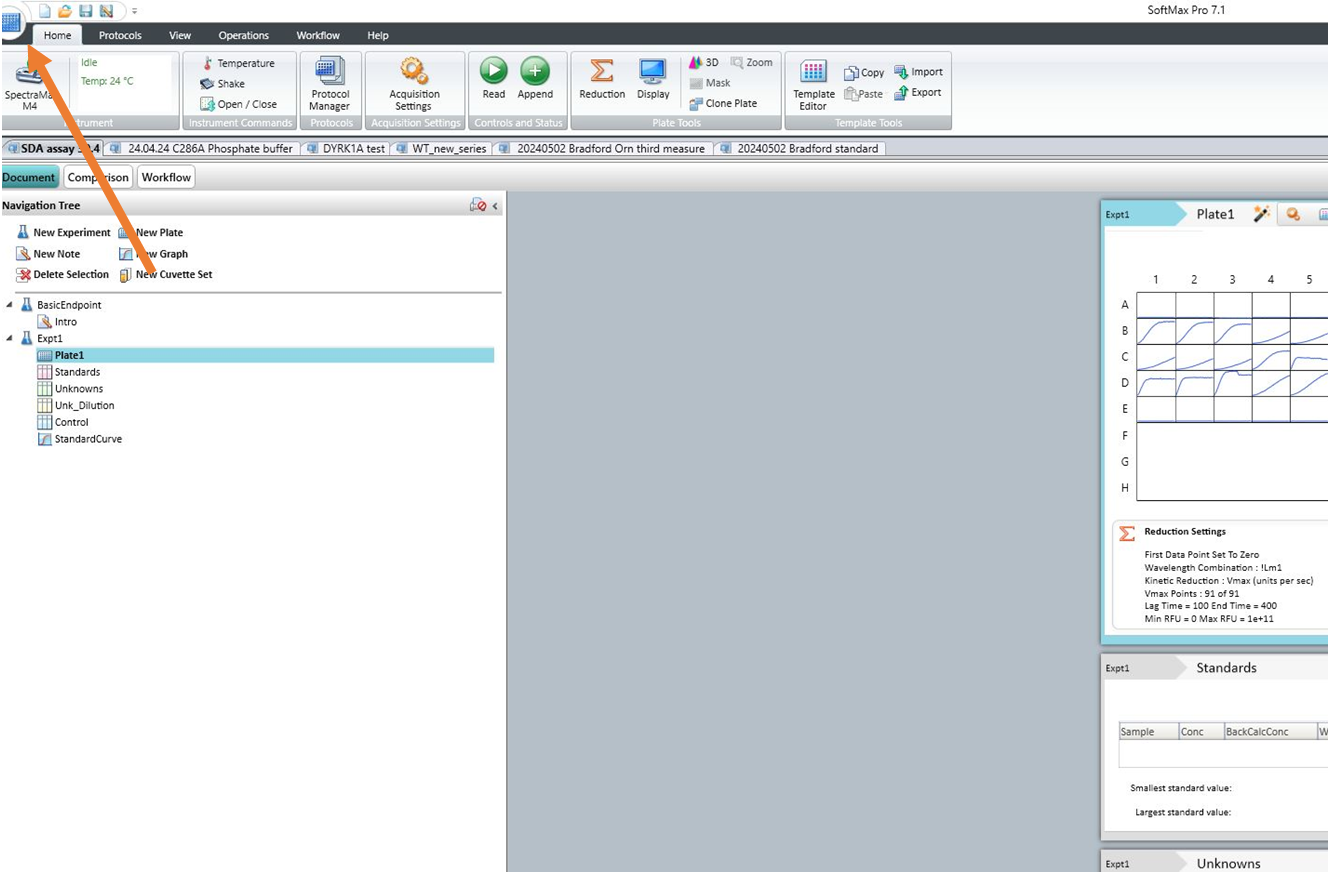

###**Step 2**: Export options

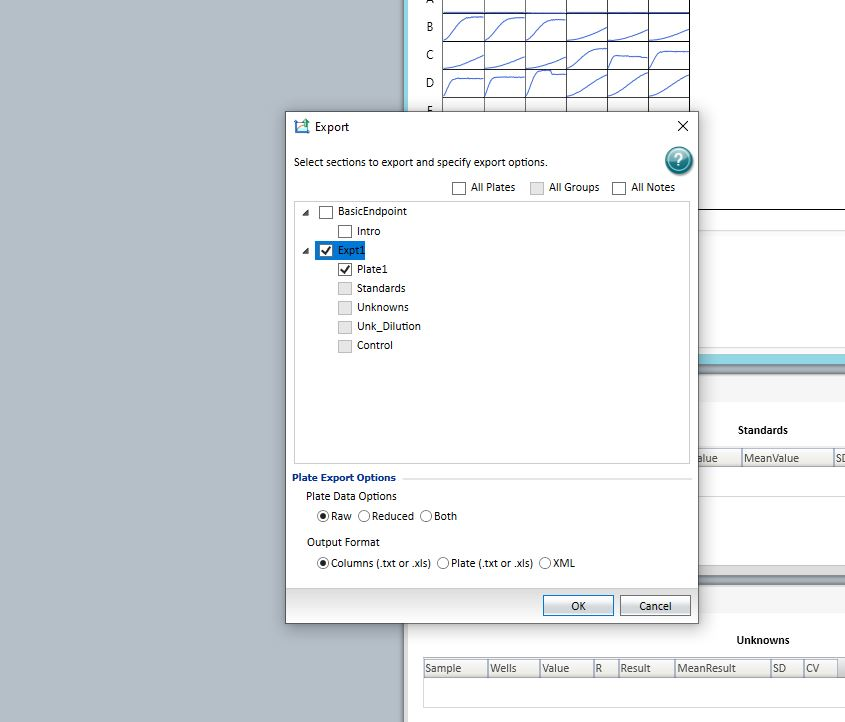

###**Step 3**: saving it as an Excel file

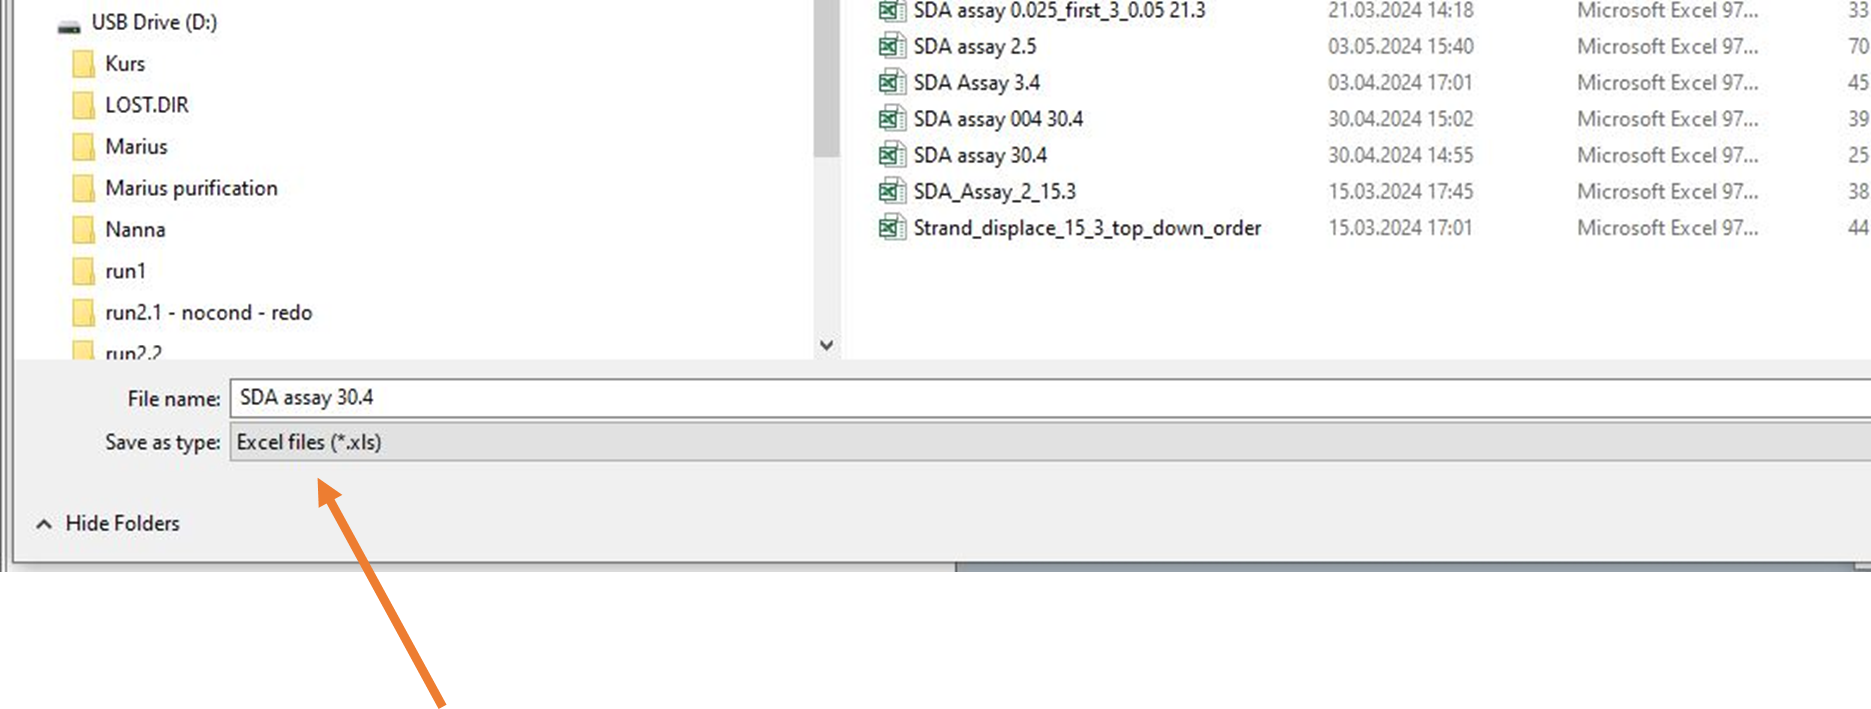

###**Step 4**: Open it in Excel and removing Header
(code is below to do it her :) however it is easier on the computer in the lab)

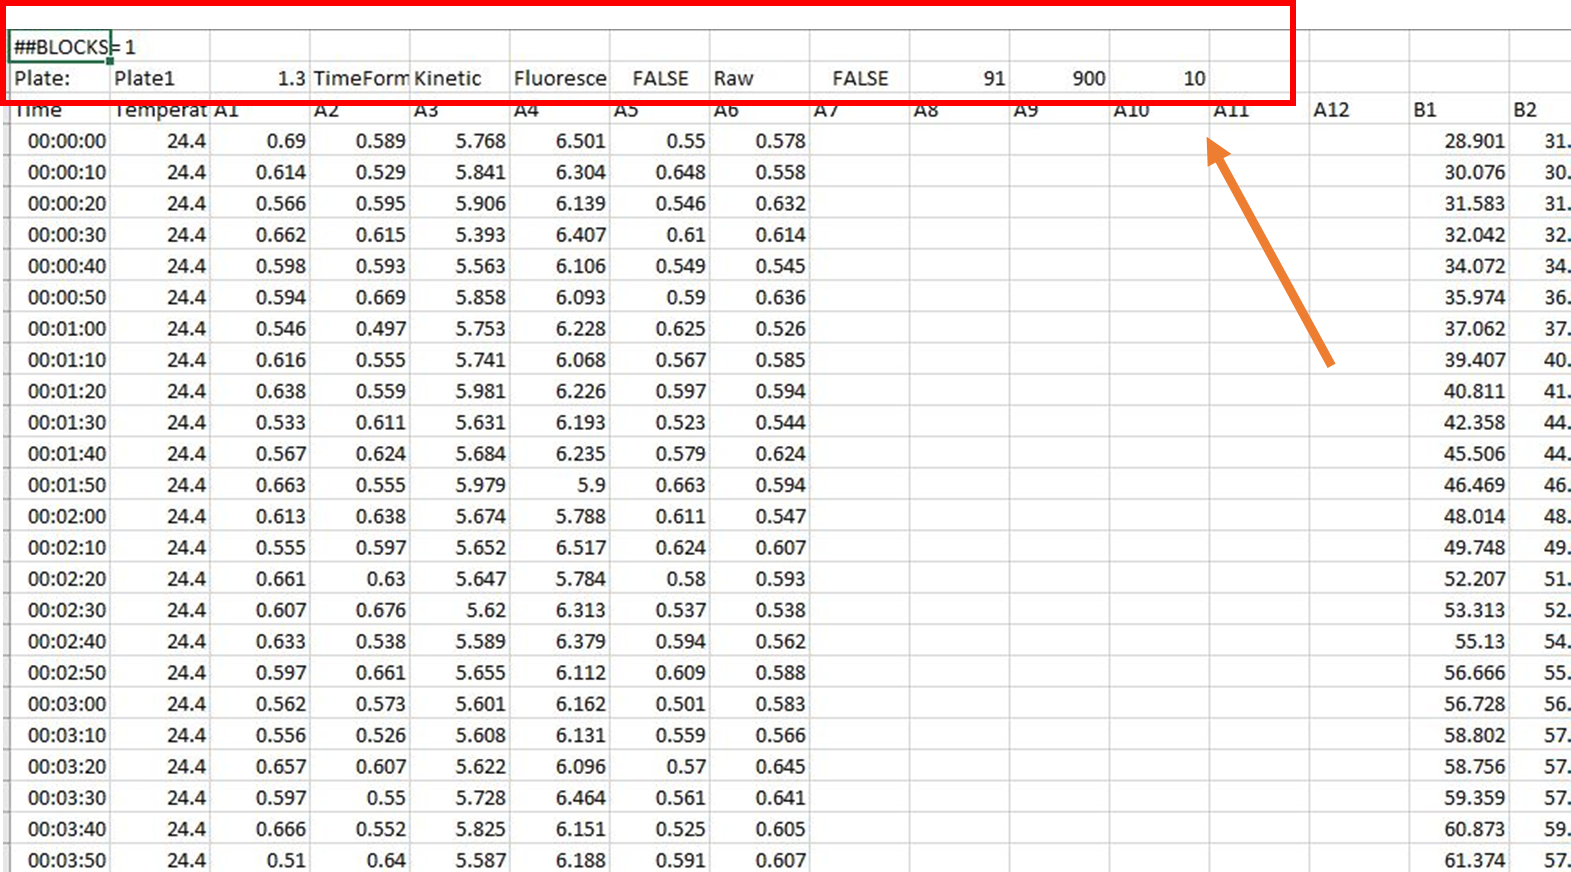

###**Step 5**: The Footer too
=> the ; (added in the empty row) can make problem when columns are deleted

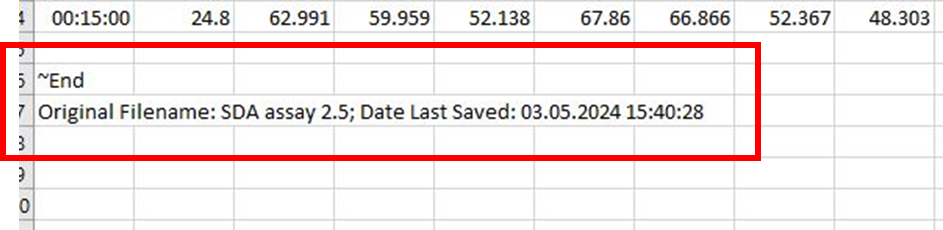

###**Step 6**: Renaming column Names: Protein Name_Concentration_Replicate

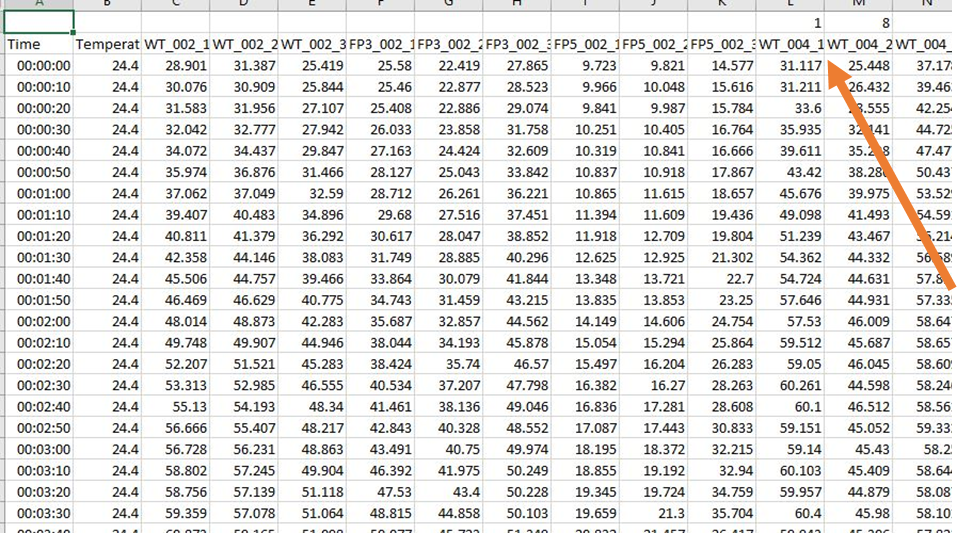

###**Step 7**: Exporting it as an CSV file (it is exported differently see code below)

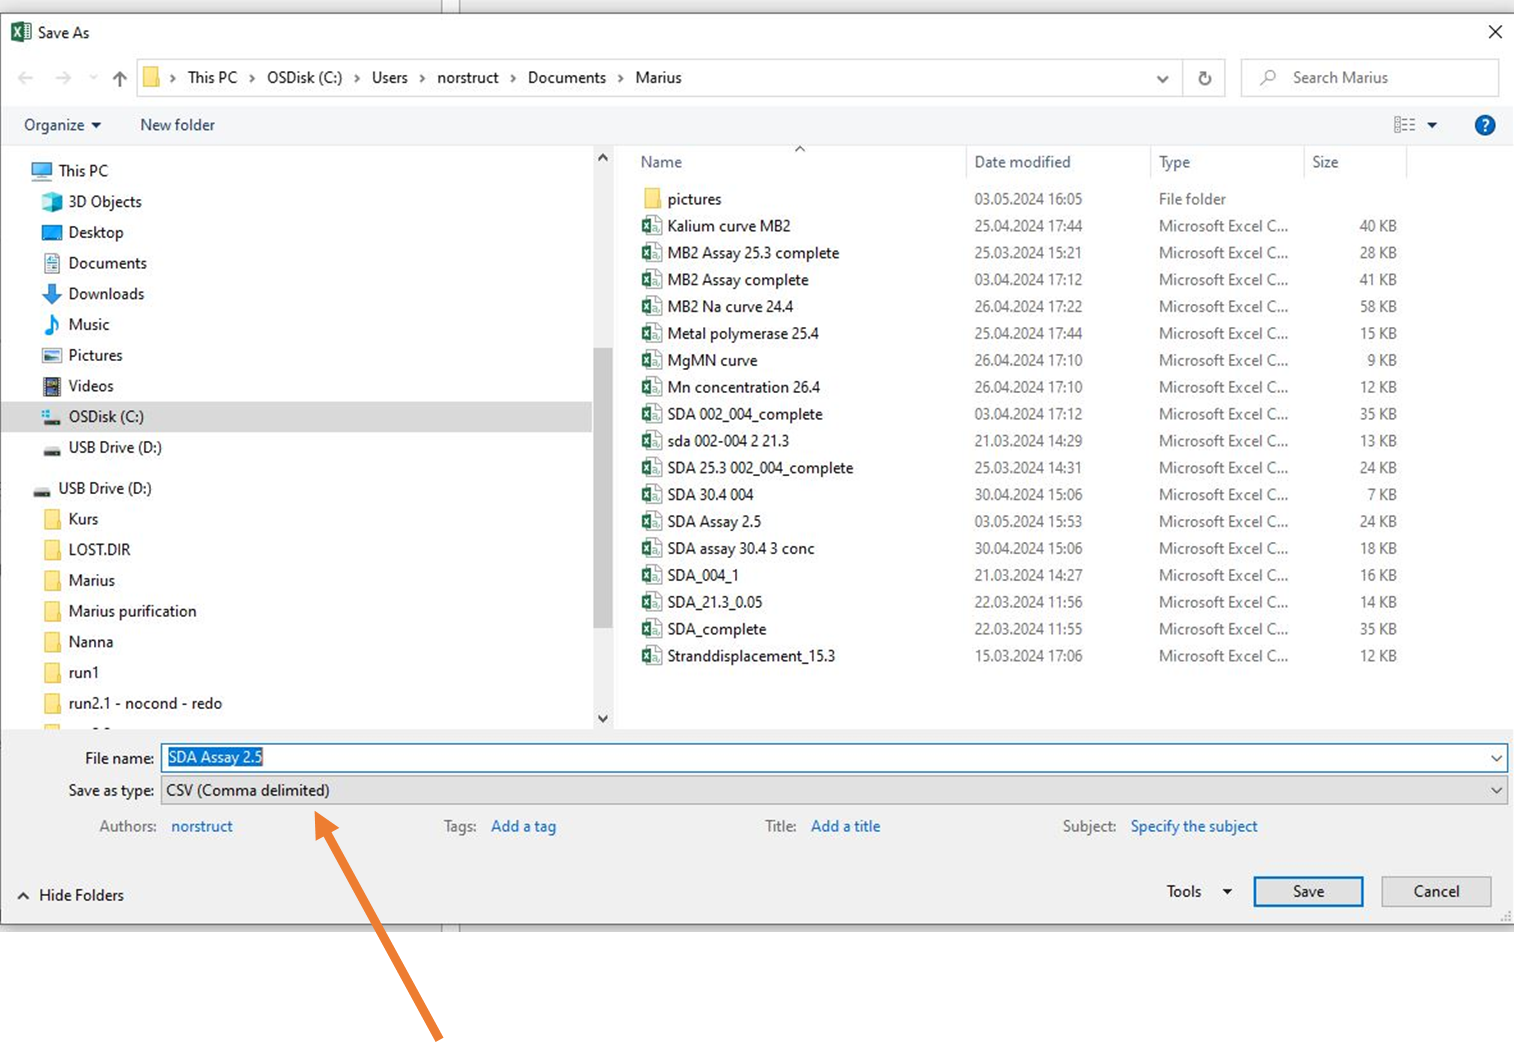

###**Step 8**: upload of the CSV file in Google Drive

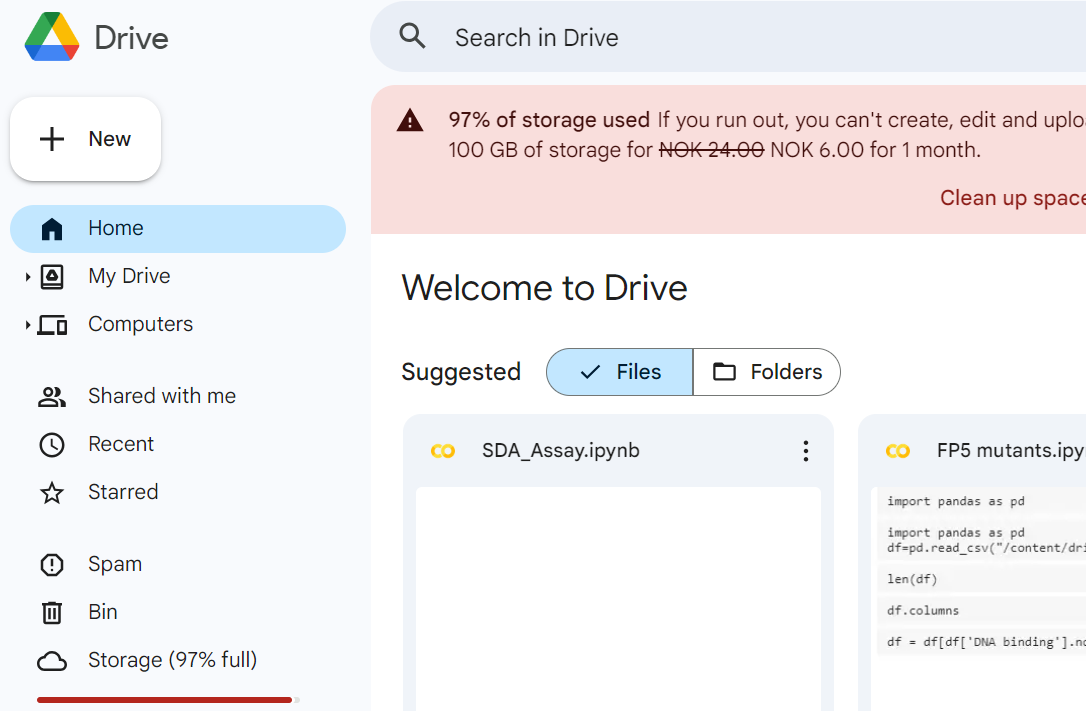

##Final Analysis

###Importing Assay Data

In [1]:
import pandas as pd

df_SDA=pd.read_csv("/content/drive/MyDrive/Mgpol MB2/all sda Mgpol.csv", encoding="ISO-8859-1", sep=";")
df_MB2=pd.read_csv("/content/drive/MyDrive/Mgpol MB2/MgPol all Mb2.csv", encoding="ISO-8859-1", sep=";")

In [2]:
#df_MB2=pd.read_csv("/content/drive/MyDrive/Mgpol MB2/all mgpol zn mb2 (1).csv", encoding="ISO-8859-1", sep=",")

###Experimental Setup

In [3]:
#proteins=["WT","3Mg","5Mg"]
window=6
volume=5
polymerase="MgPol"

In [4]:
#time=df_MB2["Time"]
#df_MB2=pd.concat([time, df_MB2],axis=1)

###Removing unnecessary Columns

In [5]:
df_MB2=df_MB2[:93]
df_SDA=df_SDA[:91]

###Setting the correct Row as Column Names

In [7]:
import pandas as pd

# Load the DataFrame (assuming df is already loaded)
#df_SDA.columns = df_SDA.iloc[0]  # Set first row as column headers
#df_SDA = df_SDA[1:].reset_index(drop=True)  # Remove the original first row


In [8]:
#df_SDA["protein"].replace({"MgPol":"PbPol(SD+)", "FP3":"FP3-PbPol(SD+)", "FP5":"FP5-PbPol(SD+)"}, inplace=True)

In [9]:
#df_MB2["protein"].replace({"MgPol":"PbPol(SD+)", "FP3":"FP3-PbPol(SD+)", "FP5":"FP5-PbPol(SD+)"}, inplace=True)

In [10]:
protein_df=df_MB2.drop(["Temperature(¡C)","Time"],axis=1)
protein_names = list(set(col.split("_")[0] for col in protein_df.columns))

# Print the unique protein names
print(protein_names)

['3Mg', 'WT', '5Mg']


###Converting Time Columns to Time

In [13]:


import pandas as pd

# Suppose df_SDA is your DataFrame
# And you're trying to convert all columns except 'Time' to numeric
columns_to_convert = df_SDA.columns.difference(['Time'])
columns_to_convert1 = df_MB2.columns.difference(['Time'])

# Here, make sure that `columns_to_convert` contains valid column names
# and none of them are 'Time'


# Now, convert the selected columns to numeric
df_SDA[columns_to_convert] = df_SDA[columns_to_convert].apply(pd.to_numeric)
df_MB2[columns_to_convert1] = df_MB2[columns_to_convert1].apply(pd.to_numeric)


<ipython-input-13-e8abdcaca1f8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SDA[columns_to_convert] = df_SDA[columns_to_convert].apply(pd.to_numeric)


In [14]:

import pandas as pd

# Dictionary of DataFrames with keys as identifiers
dfs = {
    "MB2": df_MB2,
    "SDA": df_SDA,
    # Add more if needed
}

def convert_time_to_mm_ss(df, time_column):
    # Convert "HH:MM:SS" to timedelta, then to "MM:SS"
    df[time_column] = pd.to_timedelta(df[time_column])
    df[time_column] = df[time_column].apply(lambda x: f"{int(x.total_seconds() // 60):02}:{int(x.total_seconds() % 60):02}")
    return df

# Columns to convert
columns_to_convert = ['Time']

# Update DataFrames in the dictionary
for name, df in dfs.items():
    for column in columns_to_convert:
        dfs[name] = convert_time_to_mm_ss(df, column)

###renaming Column Headers

In [15]:

def rename_columns(dfs_dict):
    """
    Replace patterns in column names across multiple DataFrames stored in a dictionary.

    Args:
        dfs_dict (dict): Dictionary where keys are identifiers and values are DataFrames.

    Returns:
        dict: Updated dictionary with renamed DataFrame columns.
    """
    for key, df in dfs_dict.items():
        df.columns = [
            col.replace("WT", "MgPol")
               .replace("3Mg-Zn(01mM)", "FP3-MgPol 0.1mM Zn")
               .replace("3Mg-Zn(10mM)", "FP3-MgPol 10mM Zn")
               .replace("3Mg", "FP3-MgPol")
               .replace("WT-Zn(10mM)", "FP3-MgPol 10mM Zn")
               .replace("5Mg", "FP5-MgPol")
            for col in df.columns
        ]
    return dfs_dict


dfs = rename_columns(dfs)




### Plotting all Assays together

In [16]:
import plotly.graph_objects as go
conc_color_mapping={
    "001":"#A62C2C",
    "002":"#E83F25",
    "01":"#EA7300",
    "005":"#D3CA79"
}

low_opacity_cols=[]
def plot_protein_time_series(dfs_dict, conc_color_mapping, low_opacity_cols=[]):
    """
    Plot absorbance vs. time for each protein across multiple DataFrames.

    Args:
        dfs_dict (dict): Dictionary of DataFrames {title_prefix: df}.
        conc_color_mapping (dict): Mapping of concentration codes to colors.
        low_opacity_cols (list): Optional list of column names with reduced opacity.
    """
    for title_prefix, df in dfs_dict.items():
        # Get unique protein names from column headers
        protein_names = {
            col.split("_")[0]
            for col in df.columns
            if "_" in col and col not in ["Time", "Temperature(¡C)"]
        }

        # Plot one figure per protein
        for protein in protein_names:
            fig = go.Figure()

            for col in df.columns:
                if "_" not in col or col in ["Time", "Temperature(¡C)"]:
                    continue

                if col.startswith(protein):
                    conc = col.split("_")[1]
                    color = conc_color_mapping.get(conc, "gray")
                    mode = "lines+markers" if col not in low_opacity_cols else "lines"
                    opacity = 0.8 if col not in low_opacity_cols else 0.3

                    fig.add_trace(go.Scatter(
                        x=df["Time"],
                        y=df[col],
                        mode=mode,
                        name=col,
                        line=dict(color=color, width=2),
                        marker=dict(size=6),
                        opacity=opacity
                    ))

            # Layout with angled ticks
            fig.update_layout(
                title=f"{title_prefix} - {protein} - Absorbance vs. Time",
                xaxis_title="Time",
                yaxis_title="Absorbance",
                template="simple_white",
                height=500,
                xaxis=dict(tickangle=45)
            ),
            fig.write_html(f"{title_prefix} - {protein} - Absorbance vs. Time.html"),
            fig.show()


plot_protein_time_series(dfs, conc_color_mapping, low_opacity_cols)


In [17]:
df_MB2.to_csv("/content/drive/MyDrive/MB2_PbPol_final")

In [18]:
df_SDA.to_csv("/content/drive/MyDrive/MB2_PbPol_final")

###Plotting Results of Individual Assays in separate Plot

####Wildtype Enzyme

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

protein = "MgPol"

def plot_sda_assay(df, df_name, low_opacity_cols=None):
    """
    Generates a Plotly subplot for fluorescence data from a given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing fluorescence data.
    df_name (str): The name of the DataFrame (e.g., 'df_MB2' or 'df_SDA').
    low_opacity_cols (set): A set of column names that should be displayed with lower opacity and no markers.
    """
    dataset_name = df_name.split('_')[-1]
    prot = protein

    if low_opacity_cols is None:
        low_opacity_cols = set()

    # Filter relevant columns
    # Filter relevant columns
    zn_columns = [col for col in df.columns if 'MgPol' in col and not col.startswith('FP5-MgPol') and not col.startswith('FP3-MgPol') and '_' in col]


    if not zn_columns:
        print(f"No valid 'WT' columns found in {df_name}.")
        return

    # Extract unique concentrations from column names
    concentrations = sorted(set(col.split('_')[1] for col in zn_columns if len(col.split('_')) > 1))

    # Define a dynamic color mapping based on concentration
    color_mapping = {
        "01": "#A94A4A",
        "005": "#F4D793",
        "002": "#D99D81",
        "004": "#889E73"
    }

    # Create subplots: 3 rows, 2 columns with shared x and y axes
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=("Experiment 1", "Experiment 2", "Experiment 3", "Experiment 4", "Experiment 5", "Experiment 6"),
        shared_xaxes=True,
        shared_yaxes=True
    )

    # Define subplot positions
    subplot_positions = {
        "1": (1, 1), "2": (1, 1), "3": (1, 2), "4": (1, 2),
        "5": (2, 1), "6": (2, 2), "7": (2, 2), "8": (2, 1)
    }

    # Iterate over filtered columns
    for col in zn_columns:
        parts = col.split('_')

        if len(parts) < 2:
            print(f"Skipping column '{col}' due to unexpected format.")
            continue

        concentration = parts[1]
        color = color_mapping.get(concentration, "gray")

        subplot_key = parts[2] if len(parts) > 2 else "1"
        row, col_num = subplot_positions.get(subplot_key, (1, 1))

        # If column is in low_opacity_cols → Hide markers, reduce line opacity
        if col in low_opacity_cols:
            mode = "lines"  # Line-only plot
            opacity = 0.3    # Reduce line opacity
        else:
            mode = "lines+markers"  # Default mode
            opacity = 0.8           # Normal opacity

        # Add trace to figure
        fig.add_trace(
            go.Scatter(
                x=df["Time"],
                y=df[col],
                mode=mode,
                name=f"{col} ({concentration} mg/mL)",
                line=dict(color=color, width=2,dash="dash"),  # Adjust opacity
                marker=dict(size=6) if mode == "lines+markers" else None  # Hide markers for low-opacity columns
            ),
            row=row, col=col_num
        )

    # Update layout
    fig.update_layout(
        title = f"Result {dataset_name} Assay - {prot}  Concentrations: {', '.join(['0.' + c[1:] for c in concentrations])} mg/mL",
        showlegend=True,
        template="simple_white",
    )

    # X-axis and Y-axis labels
    fig.update_xaxes(title_text="Time [mm:ss]", row=3, col=1)
    fig.update_xaxes(title_text="Time [mm:ss]", row=3, col=2)
    fig.update_yaxes(title_text="Fluorescence Unit [mAU]", row=1, col=1)

    # Show the plot
    fig.write_html(f"Assays_{df_name}_{protein}_individuell.html")
    fig.show()

# Example Usage with different low-opacity column lists:
low_opacity_MB2_WT = {"WT_001_1","WT_001_3","WT_002_1","WT_004_3", "WT_001_8", "WT_001_9","WT_002_8.1","WT_002_9.1","WT_004_4","WT_004_5","WT_001_10","WT_001_11","WT_002_11","WT_002_10"}
low_opacity_SDA = {}

plot_sda_assay(df_MB2, "df_MB2", low_opacity_cols=low_opacity_MB2_WT)
plot_sda_assay(df_SDA, "df_SDA", low_opacity_cols=low_opacity_SDA)



####Modified Constructs

In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

protein = "FP3-MgPol"

def plot_sda_assay(df, df_name, low_opacity_cols=None):
    """
    Generates a Plotly subplot for fluorescence data from a given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing fluorescence data.
    df_name (str): The name of the DataFrame (e.g., 'df_MB2' or 'df_SDA').
    low_opacity_cols (set): A set of column names that should be displayed with lower opacity and no markers.
    """
    dataset_name = df_name.split('_')[-1]
    prot = protein

    if low_opacity_cols is None:
        low_opacity_cols = set()

    # Filter relevant columns
    # Filter relevant columns
    zn_columns = [col for col in df.columns if 'FP3-MgPol' in col and  '_' in col]


    if not zn_columns:
        print(f"No valid 'WT' columns found in {df_name}.")
        return

    # Extract unique concentrations from column names
    concentrations = sorted(set(col.split('_')[1] for col in zn_columns if len(col.split('_')) > 1))

    # Define a dynamic color mapping based on concentration
    color_mapping = {
        "01": "#A94A4A",
        "005": "#F4D793",
        "002": "#D99D81",
        "004": "#889E73"
    }

    # Create subplots: 3 rows, 2 columns with shared x and y axes
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=("Experiment 1", "Experiment 2", "Experiment 3", "Experiment 4", "Experiment 5", "Experiment 6"),
        shared_xaxes=True,
        shared_yaxes=True
    )

    # Define subplot positions
    subplot_positions = {
        "1": (1, 1), "2": (1, 1), "3": (1, 2), "4": (1, 2),
        "5": (2, 1), "6": (2, 2), "7": (2, 2), "8": (2, 1)
    }

    # Iterate over filtered columns
    for col in zn_columns:
        parts = col.split('_')

        if len(parts) < 2:
            print(f"Skipping column '{col}' due to unexpected format.")
            continue

        concentration = parts[1]
        color = color_mapping.get(concentration, "gray")

        subplot_key = parts[2] if len(parts) > 2 else "1"
        row, col_num = subplot_positions.get(subplot_key, (1, 1))

        # If column is in low_opacity_cols → Hide markers, reduce line opacity
        if col in low_opacity_cols:
            mode = "lines"  # Line-only plot
            opacity = 0.3    # Reduce line opacity
        else:
            mode = "lines+markers"  # Default mode
            opacity = 0.8           # Normal opacity

        # Add trace to figure
        fig.add_trace(
            go.Scatter(
                x=df["Time"],
                y=df[col],
                mode=mode,
                name=f"{col} ({concentration} mg/mL)",
                line=dict(color=color, width=2,dash="dash"),  # Adjust opacity
                marker=dict(size=8) if mode == "lines+markers" else None  # Hide markers for low-opacity columns
            ),
            row=row, col=col_num
        )

    # Update layout
    fig.update_layout(
        title = f"Result {dataset_name} Assay - {prot}  Concentrations: {', '.join(['0.' + c[1:] for c in concentrations])} mg/mL",
        showlegend=True,
        template="simple_white",
    )

    # X-axis and Y-axis labels
    fig.update_xaxes(title_text="Time [mm:ss]", row=2, col=1)
    fig.update_xaxes(title_text="Time [mm:ss]", row=2, col=2)
    fig.update_yaxes(title_text="Fluorescence Unit [mAU]", row=2, col=1)
    fig.update_yaxes(title_text="Fluorescence Unit [mAU]", row=1, col=1)

    # Show the plot
    fig.write_html(f"Assays_{df_name}_{protein}_individuell.html")
    fig.show()

# Example Usage with different low-opacity column lists:
low_opacity_MB2_3 = {"FP3_001_3","FP3_002_4","FP3_001_5","FP3_001_6", "FP3_002_8", "FP3_004_1","FP3_004_5","FP3_004_6","FP3_001_10","FP3_001_11","FP3_004_7","FP3_004_4" }
low_opacity_SDA = {"FP3_002_8", "FP3_004_1", "FP3_004_5", "FP3_004_6"}

plot_sda_assay(df_MB2, "df_MB2", low_opacity_cols=low_opacity_MB2_3)
plot_sda_assay(df_SDA, "df_SDA", low_opacity_cols=low_opacity_SDA)


In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

protein = "FP5-MgPol"




def plot_sda_assay(df, df_name, low_opacity_cols=None):
    """
    Generates a Plotly subplot for fluorescence data from a given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing fluorescence data.
    df_name (str): The name of the DataFrame (e.g., 'df_MB2' or 'df_SDA').
    low_opacity_cols (set): A set of column names that should be displayed with lower opacity and no markers.
    """
    dataset_name = df_name.split('_')[-1]
    prot = protein

    if low_opacity_cols is None:
        low_opacity_cols = set()

    # Filter relevant columns
    # Filter relevant columns
    zn_columns = [col for col in df.columns if 'FP5-MgPol' in col and  '_' in col]


    if not zn_columns:
        print(f"No valid 'WT' columns found in {df_name}.")
        return

    # Extract unique concentrations from column names
    concentrations = sorted(set(col.split('_')[1] for col in zn_columns if len(col.split('_')) > 1))

    # Define a dynamic color mapping based on concentration
    color_mapping = {
        "01": "#A94A4A",
        "005": "#F4D793",
        "002": "#D99D81",
        "004": "#889E73"
    }

    # Create subplots: 3 rows, 2 columns with shared x and y axes
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=("Experiment 1", "Experiment 2", "Experiment 3", "Experiment 4", "Experiment 5", "Experiment 6"),
        shared_xaxes=True,
        shared_yaxes=True
    )

    # Define subplot positions
    subplot_positions = {
        "1": (1, 1), "2": (1, 1), "3": (1, 2), "4": (1, 2),
        "5": (2, 1), "6": (2, 2), "7": (2, 2), "8": (2, 1)
    }

    # Iterate over filtered columns
    for col in zn_columns:
        parts = col.split('_')

        if len(parts) < 2:
            print(f"Skipping column '{col}' due to unexpected format.")
            continue

        concentration = parts[1]
        color = color_mapping.get(concentration, "gray")

        subplot_key = parts[2] if len(parts) > 2 else "1"
        row, col_num = subplot_positions.get(subplot_key, (1, 1))

        # If column is in low_opacity_cols → Hide markers, reduce line opacity
        if col in low_opacity_cols:
            mode = "lines"  # Line-only plot
            opacity = 0.3    # Reduce line opacity
        else:
            mode = "lines+markers"  # Default mode
            opacity = 0.8           # Normal opacity

        # Add trace to figure
        fig.add_trace(
            go.Scatter(
                x=df["Time"],
                y=df[col],
                mode=mode,
                name=f"{col} ({concentration} mg/mL)",
                line=dict(color=color, width=2,dash="dash"),  # Adjust opacity
                marker=dict(size=8) if mode == "lines+markers" else None  # Hide markers for low-opacity columns
            ),
            row=row, col=col_num
        )





    # Update layout
    fig.update_layout(
        title = f"Result {dataset_name} Assay - {prot}  Concentrations: {', '.join(['0.' + c[1:] for c in concentrations])} mg/mL",
        showlegend=True,
        template="simple_white",
    )

    # X-axis and Y-axis labels
    fig.update_xaxes(title_text="Time [mm:ss]", row=2, col=1)
    fig.update_xaxes(title_text="Time [mm:ss]", row=2, col=2)
    fig.update_yaxes(title_text="Fluorescence Unit [mAU]", row=2, col=1)
    fig.update_yaxes(title_text="Fluorescence Unit [mAU]", row=1, col=1)

    # Show the plot
    fig.write_html(f"Assays_{df_name}_{protein}_individuell.html")
    fig.show()

# Example Usage with different low-opacity column lists:
low_opacity_MB2_5 = {"FP5_001_3","FP5_001_4","FP5_001_5","FP5_001_6", "FP5_001_8", "FP5_001_9","FP5_001_10","FP5_002_8.1","FP5_002_9.1","FP5_002_10","FP5_004_1","FP5_004_4","FP5_001_11","FP5_004_5"}
low_opacity_SDA_5 = {"FP5_004_6"}

plot_sda_assay(df_MB2, "df_MB2", low_opacity_cols=low_opacity_MB2_5)
plot_sda_assay(df_SDA, "df_SDA", low_opacity_cols=low_opacity_SDA_5)

##Analysis for Maximum Acitivty in each Assay

###dropping outliers

In [22]:
df_MB2.columns = df_MB2.columns.str.replace("FP3", "3Mg").str.replace("FP5", "5Mg")

In [23]:
# Rename FP3 → 3Mg and FP5 → 5Mg in DataFrame columns
df_MB2.columns = df_MB2.columns.str.replace("FP3", "3Mg").str.replace("FP5", "5Mg")

# Define the list of columns to drop
columns_to_drop = [
    "3Mg_001_2", "3Mg_001_11", "3Mg_004_7", "3Mg_004_4",
    "5Mg_001_11", "5Mg_004_5", "WT_001_2",
    "WT_001_1", "WT_001_3", "WT_002_1", "WT_004_3", "WT_001_8",
    "WT_001_9", "WT_002_8.1", "WT_002_9.1", "WT_004_4", "WT_004_5",
    "WT_001_10", "WT_001_11", "WT_002_11", "WT_002_10",
    "5Mg_001_3", "5Mg_001_4", "5Mg_001_5", "5Mg_001_6", "5Mg_001_8",
    "5Mg_001_9", "5Mg_001_10", "5Mg_002_8.1", "5Mg_002_9.1",
     "5Mg_004_1", "5Mg_004_4",
    "3Mg_001_3", "3Mg_002_4", "3Mg_001_5", "3Mg_002_8",
    "3Mg_004_1", "3Mg_004_5", "3Mg_004_6", "3Mg_002_10", "3Mg_002_2",

]

# Drop only columns that exist in the DataFrame
#df_MB2.drop(columns=set(columns_to_drop) & set(df_MB2.columns), inplace=True)


###Dropping Temperature and Time column

In [24]:

def remove_temp_time(df):
  df=df.drop(["Temperature(¡C)","Time"],axis=1)
  return df

for key in dfs:
    dfs[key] = remove_temp_time(dfs[key])



###Finding Maximal Slope for each trace

In [25]:
def process_rolling_difference_dict(dfs_dict, window_size):
    """
    Processes a dictionary of DataFrames by applying a rolling difference,
    removing the first 'window_size' indices, resetting the index,
    and calculating the index of the max slope.

    Parameters:
    dfs_dict (dict): Dictionary of DataFrames to process.
    window_size (int): The size of the rolling window.

    Returns:
    dict: Dictionary where each key maps to a tuple (processed_df, max_slope_df).
    """
    def calculate_difference(window):
        return window.iloc[-1] - window.iloc[0]

    results = {}

    for key, df in dfs_dict.items():
        rolling_diff = df.rolling(window=window_size).apply(calculate_difference)
        rolling_diff_cleaned = rolling_diff.drop(index=range(1, window_size)).reset_index(drop=True)
        max_slope_index = rolling_diff_cleaned.idxmax()

        max_slope_df = pd.DataFrame(max_slope_index, columns=["Index max slope"])
        max_slope_df = max_slope_df.apply(pd.to_numeric, errors="coerce")
        max_slope_df["end max Window"] = max_slope_df["Index max slope"] + window_size

        results[key] = (rolling_diff_cleaned, max_slope_df)

    return results


# Access processed DataFrame and max slope index:


window_size = 5  # or whatever value you need
processed_results = process_rolling_difference_dict(dfs, window_size)




In [26]:
#processed_df_MB2, max_slope_MB2 = processed_results["MB2"]

###extracting the maximum range for each value

In [28]:
import pandas as pd

def extract_max_value_windows(dfs_dict, results_dict):
    """
    Extracts max values in the range from 'Index max slope' to 'end max Window'
    for each DataFrame and stores them in a nested dictionary.

    Parameters:
    dfs_dict (dict): Dictionary of original DataFrames.
    results_dict (dict): Dictionary where values are tuples (processed_df, max_slope_df).

    Returns:
    dict: Nested dictionary with structure {name: {column: [[values]]}}.
    """
    max_values = {}

    for name, (processed_df, max_slope_df) in results_dict.items():
        df = dfs_dict[name]
        max_values[name] = {}

        for index_name, row in max_slope_df.iterrows():
            start = row["Index max slope"]
            end = row["end max Window"]

            if pd.notna(start) and pd.notna(end):
                start_index = int(start)
                end_index = int(end)

                if index_name in df.columns:
                    column = df[index_name]
                    max_v = column.iloc[start_index:end_index]

                    max_values[name].setdefault(index_name, []).append(max_v.tolist())

    return max_values

max_values = extract_max_value_windows(dfs, processed_results)

In [29]:
import pandas as pd

dataframes = {}  # Dictionary to store DataFrames for each name_

# Process the results from max_values
for name_, sub_values in max_values.items():
    data = {}  # Temporary dictionary to hold data for the current name_

    for name, values in sub_values.items():
        key = f"{name_}_{name}"

        # Extract inner list if it's wrapped in another list
        if isinstance(values, list) and len(values) == 1 and isinstance(values[0], list):
            values = values[0]  # Unwrap the nested list

        data[key] = values

    # Convert dictionary to DataFrame
    df_expanded = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})

    # Store in dictionary
    dataframes[name_] = df_expanded

# Now, each name_ has its own DataFrame stored in dataframes[name_]


In [30]:
dataframes.keys()

dict_keys(['MB2', 'SDA'])

###determining slope and R2

In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

difference_df = {}  # Initialize the difference DataFrame dictionary

# Loop through dataframes in `dataframes`
for name, df in dataframes.items():
    # Initialize the lists to store results
    correlation_coeffs = []
    r_squared_values = []
    max_values = []

    difference_df[name] = {}  # Initialize the dictionary for the current name

    # Loop through columns in the dataframe
    for col in df.columns:
        # Get the series for the current column
        series = df[col]

        # Ensure that the index is numeric
        df.index = pd.to_numeric(df.index, errors='coerce')

        # Ensure that the series is numeric
        series = pd.to_numeric(series, errors='coerce')

        # Handle any NaN values after coercion (optional, depending on your use case)
        if series.isna().any():
            print(f"Warning: NaN values found in column {col}. Dropping them.")
            series = series.dropna()

        # Calculate linear trendline for the current column
        z = np.polyfit(df.index, series, 1)  # Fit a 1st degree polynomial (linear)
        p = np.poly1d(z)  # Create a polynomial function

        # Calculate R-squared value for the trendline
        r_squared = r2_score(series, p(df.index))

        # Calculate correlation coefficient with respect to index
        correlation_coeff = series.corr(pd.Series(df.index, index=df.index))

        # Calculate the difference between the first and last values in the current column
        max_value = series.iloc[-1] - series.iloc[0]

        # Store the results in the dictionary for the current column
        difference_df[name][col] = {
            'correlation_coeff': correlation_coeff,
            'r_squared': r_squared,
            'max_value': max_value
        }

# Now `difference_df` contains the results for each column in each dataframe


In [32]:
import pandas as pd

# Initialize the DataFrames for 'MB2' and 'SDA'
df_mb2 = {}
df_sda = {}

# Loop through the `difference_df` dictionary to filter and create the DataFrames
for name, columns in difference_df.items():
    # For 'MB2' and 'SDA', separate data into their respective DataFrames
    for col_name, data in columns.items():
        if name.startswith('MB2'):
            if col_name not in df_mb2:
                df_mb2[col_name] = []
            df_mb2[col_name].append(data)
        elif name.startswith('SDA'):
            if col_name not in df_sda:
                df_sda[col_name] = []
            df_sda[col_name].append(data)

# Now create DataFrames with the correct structure
# Ensure the index corresponds to the names and the columns to 'correlation_coeff', 'r_squared', and 'max_value'

# Create 'MB2' DataFrame
mb2_index = []
mb2_corr_coeff = []
mb2_r_squared = []
mb2_max_value = []

# Loop through df_mb2 to create the lists for the final DataFrame
for name in df_mb2:
    for col_data in df_mb2[name]:
        mb2_index.append(f"{name}")
        mb2_corr_coeff.append(col_data['correlation_coeff'])
        mb2_r_squared.append(col_data['r_squared'])
        mb2_max_value.append(col_data['max_value'])

df_mb2_final = pd.DataFrame({
    "Correlation Coefficient": mb2_corr_coeff,
    "R-squared Value": mb2_r_squared,
    "Max Slope": mb2_max_value
}, index=mb2_index)

# Create 'SDA' DataFrame
sda_index = []
sda_corr_coeff = []
sda_r_squared = []
sda_max_value = []

# Loop through df_sda to create the lists for the final DataFrame
for name in df_sda:
    for col_data in df_sda[name]:
        sda_index.append(f"{name}")
        sda_corr_coeff.append(col_data['correlation_coeff'])
        sda_r_squared.append(col_data['r_squared'])
        sda_max_value.append(col_data['max_value'])

df_sda_final = pd.DataFrame({
    "Correlation Coefficient": sda_corr_coeff,
    "R-squared Value": sda_r_squared,
    "Max Slope": sda_max_value
}, index=sda_index)

# Print the DataFrames
df_analysis = {
    "MB2": df_mb2_final,
    "SDA": df_sda_final
}








###Investigating the slope and max Range Position

In [34]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# --- Define experiment info ---
columns_by_experiment = {
    "MB2": ['MgPol_002_2', "MgPol_002_1"],
    "SDA": ['FP3-MgPol_01_6', 'FP3-MgPol_01_5']
}

# --- Loop through experiments ---
for exp_name, columns_to_plot in columns_by_experiment.items():
    df = dfs[exp_name]
    processed_df, max_slope = processed_results[exp_name]

    n = len(columns_to_plot)
    rows = (n + 1) // 2
    cols = 2 if n > 1 else 1

    fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f"<b>{col}</b>" for col in columns_to_plot])

    for i, col in enumerate(columns_to_plot):
        row = (i // 2) + 1
        col_pos = (i % 2) + 1

        x_vals = df.index
        y_vals = df[col]

        x_peak = int(max_slope.loc[col, 'Index max slope'])
        x_end = int(max_slope.loc[col, 'end max Window'])

        # Highlight slope region
        colors = ['blue'] * len(x_vals)
        for idx in range(x_peak, min(x_end + 1, len(x_vals))):
            colors[idx] = 'red'

        fig.add_trace(go.Scatter(
            x=x_vals, y=y_vals, mode='markers',
            marker=dict(color=colors), name=col
        ), row=row, col=col_pos)

        # Fit only in slope region
        x_fit_vals = x_vals[x_peak:x_end + 1]
        y_fit_vals = y_vals.iloc[x_peak:x_end + 1]

        if len(x_fit_vals) >= 2:
            z = np.polyfit(x_fit_vals, y_fit_vals, 1)
            p = np.poly1d(z)

            # Extrapolate a bit outside the window
            x_trend = x_vals[max(0, x_peak - 5):min(x_end + 6, len(x_vals))]

            fig.add_trace(go.Scatter(
                x=x_trend, y=p(x_trend), mode='lines',
                name=f'Trendline {col}', line=dict(dash='dash')
            ), row=row, col=col_pos)

            # R² value from fit
            r2 = np.corrcoef(y_fit_vals, p(x_fit_vals))[0, 1]**2
            fig.add_annotation(
                text=f"R² = {r2:.2f}",
                xref="x domain", yref="y domain",
                x=0.95, y=0.05, showarrow=False,
                row=row, col=col_pos
            )

        # Add vertical shaded rectangle for slope range
        fig.add_vrect(
            x0=x_vals[x_peak], x1=x_vals[x_end-1],
            fillcolor="red", opacity=0.2,
            layer="below", line_width=0,
            row=row, col=col_pos
        )

    # Final layout
    fig.update_layout(
        height=300 * rows, width=900,
        title_text=f"<b>{exp_name} Measurements with Max Slope Highlights</b>",
        showlegend=False
    )
    fig.update_yaxes(title_text="Fluorescence [mAU]")
    fig.update_xaxes(title_text="Window position")

    fig.show()


###extracting remaining infos from the index => Protein, Concentration, Experiment

In [35]:
df_edited = {}
for name, df in df_analysis.items():
    # Convert the index to a Series
    df["experiment"] = [index.split('_')[0] for index in df.index]
    df["protein"] = [index.split('_')[1] for index in df.index]
    df["Concentration"] = [index.split('_')[2] for index in df.index]

    # Add a dot after the first character in the Concentration column
    df["Concentration"] = df["Concentration"].apply(lambda x: x[0] + '.' + x[1:])
    df["Concentration"] = df["Concentration"].astype(float)

    # Normalize activity
    enzyme_volume = volume  # Make sure 'volume' is defined earlier
    df["max_activity_norm"] = df["Max Slope"] / df["Concentration"] / enzyme_volume

    # Save the edited DataFrame
    df_edited[name] = df.copy()  # Or assign directly if you don't need to preserve the original


In [53]:
def update_experiment_data(df_analysis):
    """
    This function iterates over each DataFrame in the df_analysis dictionary,
    replaces values in the 'protein' column, and adds a 'Polymerase' column.

    Parameters:
    df_analysis (dict): A dictionary with experiment names as keys and DataFrames as values.

    Returns:
    dict: A dictionary with updated DataFrames.
    """
    # Iterate over each DataFrame in df_analysis
    for name, df in df_analysis.items():
        # Replace values in the 'protein' column
        df["protein"] = df["protein"].replace({"WT": "MgPol", "3Mg": "FP3-MgPol", "5Mg": "FP5-MgPol"})

        # Add the 'Polymerase' column and set its value to "MgPol" for all rows
        df["Polymerase"] = "MgPol"

        # Optionally, print or inspect the changes to ensure they're correct
        #print(f"Updated {name} experiment:")
        #print(df.head())  # Display the first few rows to verify the changes

    # Return the updated dictionary with DataFrames
    return df_analysis

df_analysis = update_experiment_data(df_analysis)


###Exporting both DataFrames as csv file

In [38]:
names=["MB2","SDA"]
run=polymerase
for name, df in df_analysis.items():
    df.to_csv(f"/content/x_{name}_{run}_.csv", index=False)

In [39]:
#df_MB2=pd.read_csv("/content/drive/MyDrive/Mgpol MB2/MB2_MgPol_.csv")
#df_SDA=pd.read_csv("/content/drive/MyDrive/Mgpol MB2/SDA_MgPol_.csv")
#df_edited=[df_MB2,df_SDA]



##Plotting the Result

####Importing Result for Multiple Polymerases

In [40]:
import pandas as pd

In [41]:
SDA_PB=pd.read_csv("/content/drive/MyDrive/Mgpol MB2/SDA_PbPol_.csv")
SDA_PB["Polymerase"]="PbPol(SD+)"

In [42]:
import pandas as pd
MB2_PB=pd.read_csv("/content/drive/MyDrive/Mgpol MB2/MB2_PbPol_.csv")
MB2_PB["Polymerase"]="PbPol(SD+)"
MB2_Mg=pd.read_csv("/content/x_MB2_MgPol_.csv")

SDA_Mg=pd.read_csv("/content/x_SDA_MgPol_.csv")

###Renaming columns and Setting a Custom Order

In [45]:
MB2_PB.replace({"MgPol":"PbPol(SD+)","FP3":"FP3-PbPol(SD+)", "FP5":"FP5-PbPol(SD+)"},inplace=True)
MB2_Mg.replace({"3Mg-MgPol":"FP3-MgPol", "5Mg-MgPol":"FP5-MgPol"},inplace=True)
SDA_PB.replace({"MgPol":"PbPol(SD+)","FP3":"FP3-PbPol(SD+)", "FP5":"FP5-PbPol(SD+)"},inplace=True)

In [46]:
SDA_all=pd.concat([SDA_Mg,SDA_PB])
MB2_all=pd.concat([MB2_Mg,MB2_PB])



####setting the order in which the values are plotted

In [47]:
custom_order=['MgPol', 'FP3-MgPol', 'FP5-MgPol', 'PbPol(SD+)', 'FP3-PbPol(SD+)', "FP5-PbPol(SD+)"]

MB2_all["protein"] = pd.Categorical(MB2_all["protein"], categories=custom_order, ordered=True)
MB2_all = MB2_all.sort_values(by="protein")




In [48]:
SDA_PB.replace({"MgPol":"PbPol(SD+)","FP3":"FP3-PbPol(SD+)", "FP5":"FP5-PbPol(SD+)"},inplace=True)

In [49]:
all_dfs = {"SDA": SDA_all, "MB2": MB2_all}

for name, df in all_dfs.items():
    print(f"--- {name} ---")
    print("Experiments:", df["experiment"].unique())
    print("Polymerases:", df["Polymerase"].unique())


--- SDA ---
Experiments: ['SDA']
Polymerases: ['MgPol' 'PbPol(SD+)']
--- MB2 ---
Experiments: ['MB2']
Polymerases: ['MgPol' 'PbPol(SD+)']


###Plotting result and Exporting Plot to Content

In [50]:
for name, df in all_dfs.items():
    # Get experiment name from the first row
    experiment_name = df["experiment"].iloc[0].replace(" ", "_")  # Optional: Replace spaces with underscores

    grouped = df.groupby(["experiment", "protein"])["max_activity_norm"].agg(
        median=lambda x: round(x.median(), 3),
        std=lambda x: round(x.std(), 3),
        mean=lambda x: round(x.mean(), 3),
        min=lambda x: round(x.min(), 3),
        q25=lambda x: round(x.quantile(0.25), 3),
        q75=lambda x: round(x.quantile(0.75), 3),
        max=lambda x: round(x.max(), 3)
    )

    # Export to CSV with a unique file name
    grouped.to_csv(f"/content/{experiment_name}_summary.csv")

    print(df["Polymerase"].unique())



['MgPol' 'PbPol(SD+)']
['MgPol' 'PbPol(SD+)']


<ipython-input-50-3ef46cd33a9f>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [51]:
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp

def plot_multiple_boxplots(name, df):
    """
    This function creates boxplots for multiple experiments, polymerases, and proteins.

    Parameters:
    - name: The name of the experiment
    - df: DataFrame containing the data for plotting
    """
    color_map = {
        "MgPol": "#979dac",
        "FP3-MgPol": "#cc5803",
        "FP3-MgPol-Zn": "#6E8E59",
        "FP5-MgPol": "#0353a4",
        "PbPol(SD+)": "#E195AB",
        "FP5-PbPol(SD+)": "#A9B5DF",
        "FP3-PbPol(SD+)": "#A7B49E",
        "FP3-Mg.fsa": "#cc5803",
        "FP3-Mg-Zn.fsa": "#e2711d",
        "FP5": "#0353a4"
    }

    unique_experiments = df["experiment"].unique()
    unique_polymerases = df["Polymerase"].unique()

    num_rows = len(unique_experiments)
    num_cols = len(unique_polymerases)

    fig = sp.make_subplots(
        rows=num_rows, cols=num_cols,
        shared_yaxes=False,
        subplot_titles=[f"{exp} - {poly}" for exp in unique_experiments for poly in unique_polymerases]
    )

    for row_idx, exp in enumerate(unique_experiments, start=1):
        for col_idx, poly in enumerate(unique_polymerases, start=1):
            df_filtered = df[(df["experiment"] == exp) & (df["Polymerase"] == poly)]
            if df_filtered.empty:
                continue

            min_y = df_filtered["max_activity_norm"].min() * 0.9
            max_y = df_filtered["max_activity_norm"].max() * 1.1

            for protein in df_filtered["protein"].unique():
                df_protein = df_filtered[df_filtered["protein"] == protein]
                median_val = df_protein["max_activity_norm"].median()

                std_val = df_protein["max_activity_norm"].std()
                print(f"Experiment: {exp}, Polymerase: {poly}, Protein: {protein}, median: {median_val:.2f}, Std: {std_val:.2f}")

                color_hex = color_map.get(protein, "#979dac")
                r, g, b = int(color_hex[1:3], 16), int(color_hex[3:5], 16), int(color_hex[5:7], 16)
                fill_color = f"rgba({r}, {g}, {b}, 0.5)"

                box_trace = go.Box(
                    x=[protein] * len(df_protein),
                    y=df_protein["max_activity_norm"],
                    name=f"{exp} - {poly} {protein}",
                    fillcolor=fill_color,
                    line=dict(color=color_hex),
                    boxpoints='suspectedoutliers',
                    notched=True,
                    marker=dict(outliercolor='rgba(219, 64, 82, 0.6)')
                )

                fig.add_trace(box_trace, row=row_idx, col=col_idx)

            # Set unique y-axis for each subplot
            fig.update_yaxes(
                title_text=r"$\text{max activity} \left[\frac{\Delta\text{mAU}}{\text{min mg}_{\text{Protein}}}\right]$",
                range=[min_y, max_y],
                row=row_idx, col=col_idx
            )

    fig.update_layout(
        title=f"<b> Results for {exp} Assay MgPol and PbPol</b>",
        title_font=dict(size=28, color="black", family="Tahoma"),
        showlegend=False,
        height=400 * num_rows,
        title_x=0.5,
        annotations=[dict(
            text="<b>Protein</b>",
            x=0.5,
            y=-0.25,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=22, family="Tahoma", color="black"),

        )],
    )

    fig.update_xaxes(tickfont=dict(size=18, family="Tahoma", color="black"))
    fig.update_yaxes(tickfont=dict(size=20, family="Tahoma", color="black"))

    fig.write_html(f"boxplot_{name}.html")
    fig.show()


# Assuming `all_dfs` is a dictionary where each entry is a DataFrame
# Example: {'experiment1': df1, 'experiment2': df2, ...}

# Loop through each DataFrame in the dictionary
for name, df in all_dfs.items():
    plot_multiple_boxplots(name, df)


Experiment: SDA, Polymerase: MgPol, Protein: MgPol, median: 35.13, Std: 7.11
Experiment: SDA, Polymerase: MgPol, Protein: FP3-MgPol, median: 22.24, Std: 10.45
Experiment: SDA, Polymerase: MgPol, Protein: FP5-MgPol, median: 13.89, Std: 4.64
Experiment: SDA, Polymerase: PbPol(SD+), Protein: PbPol(SD+), median: 88.03, Std: 14.98
Experiment: SDA, Polymerase: PbPol(SD+), Protein: FP3-PbPol(SD+), median: 65.85, Std: 12.28
Experiment: SDA, Polymerase: PbPol(SD+), Protein: FP5-PbPol(SD+), median: 41.51, Std: 13.04


Experiment: MB2, Polymerase: MgPol, Protein: MgPol, median: 1033.49, Std: 305.03
Experiment: MB2, Polymerase: MgPol, Protein: FP3-MgPol, median: 751.42, Std: 234.83
Experiment: MB2, Polymerase: MgPol, Protein: FP5-MgPol, median: 966.69, Std: 280.50
Experiment: MB2, Polymerase: PbPol(SD+), Protein: PbPol(SD+), median: 437.94, Std: 122.18
Experiment: MB2, Polymerase: PbPol(SD+), Protein: FP3-PbPol(SD+), median: 239.50, Std: 53.58
Experiment: MB2, Polymerase: PbPol(SD+), Protein: FP5-PbPol(SD+), median: 316.62, Std: 47.91
